In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 17.8 MB/s eta 0:00:00


In [26]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.datasets import cifar10
from keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [4]:
num_classes = 10
input_shape = (32, 32, 3)
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
n=5000
x_train = x_train[1:n]; y_train=y_train[1:n]
x_test=x_test[1:500]; y_test=y_test[1:500]
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("orig x_train shape:", x_train.shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 13s 0us/step
orig x_train shape: (4999, 32, 32, 3)


## SGD

In [10]:
import time
start = time.time()
# Define function to evaluate hyperparameters
def evaluate_hyperparameters(hyperparameters):
    # Define model architecture
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:],activation='relu'))
    model.add(Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1(0.0001)))

    # Compile model with SGD optimizer and given learning rate and momentum
    optimizer = SGD(learning_rate=hyperparameters['learning_rate'], momentum=hyperparameters['momentum'], nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train model
    history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), verbose=0)

    # Return validation accuracy
    return history

# Define function to perform pattern search hyperparameter optimization
def pattern_search_hyperparameter_optimization():
  # Initialize hyperparameters
  current_hyperparameters = {
      'learning_rate': np.random.uniform(0.0001, 0.01),
      'momentum': np.random.uniform(0.0, 1.0)
  }

  # Initialize search direction
  search_direction = {
      'learning_rate': 1.0,
      'momentum': 1.0
  }

  # Initialize step size
  step_size = 0.01

  # Initialize best hyperparameters and validation accuracy
  best_hyperparameters = current_hyperparameters.copy()
  best_validation_accuracy = -1

  # Define number of iterations and convergence threshold
  max_iterations = 20
  convergence_threshold = 0.001

  # Perform pattern search hyperparameter optimization
  for i in range(max_iterations):
    print(f'Iteration {i+1}:')
    print(f'Current hyperparameters: {current_hyperparameters}')
    history = evaluate_hyperparameters(current_hyperparameters)
    val_accuracy = history.history['val_accuracy'][-1]
    print(f'Current validation accuracy: {val_accuracy}')
    print(f'Best hyperparameters: {best_hyperparameters}')
    print(f'Best validation accuracy: {best_validation_accuracy}')

    # Update best hyperparameters if current validation accuracy is higher
    if val_accuracy > best_validation_accuracy:
        best_hyperparameters = current_hyperparameters.copy()
        best_validation_accuracy = val_accuracy

    # Evaluate hyperparameters in positive search direction
    positive_hyperparameters = {
        'learning_rate': current_hyperparameters['learning_rate'] + search_direction['learning_rate'] * step_size,
        'momentum': current_hyperparameters['momentum'] + search_direction['momentum'] * step_size
    }
    positive_history = evaluate_hyperparameters(positive_hyperparameters)
    positive_val_accuracy = positive_history.history['val_accuracy'][-1]

    # Evaluate hyperparameters in negative search direction
    negative_hyperparameters = {
        'learning_rate': current_hyperparameters['learning_rate'] - search_direction['learning_rate'] * step_size,
        'momentum': current_hyperparameters['momentum'] - search_direction['momentum'] * step_size
    }
    negative_history = evaluate_hyperparameters(negative_hyperparameters)
    negative_val_accuracy = negative_history.history['val_accuracy'][-1]

    # Determine new search direction
    if positive_val_accuracy > best_validation_accuracy:
        current_hyperparameters = positive_hyperparameters
    elif negative_val_accuracy > best_validation_accuracy:
        current_hyperparameters = negative_hyperparameters
    else:
        step_size /= 2.0

  # Return the best hyperparameters and validation accuracy
  return best_hyperparameters, best_validation_accuracy
best_hyperparameters = pattern_search_hyperparameter_optimization()

Iteration 1:
Current hyperparameters: {'learning_rate': 0.006528093238201973, 'momentum': 0.736726819896571}
Current validation accuracy: 0.292585164308548
Best hyperparameters: {'learning_rate': 0.006528093238201973, 'momentum': 0.736726819896571}
Best validation accuracy: -1
Iteration 2:
Current hyperparameters: {'learning_rate': 0.016528093238201973, 'momentum': 0.746726819896571}
Current validation accuracy: 0.4248496890068054
Best hyperparameters: {'learning_rate': 0.006528093238201973, 'momentum': 0.736726819896571}
Best validation accuracy: 0.292585164308548
Iteration 3:
Current hyperparameters: {'learning_rate': 0.016528093238201973, 'momentum': 0.746726819896571}
Current validation accuracy: 0.34268537163734436
Best hyperparameters: {'learning_rate': 0.016528093238201973, 'momentum': 0.746726819896571}
Best validation accuracy: 0.4248496890068054
Iteration 4:
Current hyperparameters: {'learning_rate': 0.016528093238201973, 'momentum': 0.746726819896571}
Current validation accu

In [14]:
# Best Parameters
Best_hyperparameters =  best_hyperparameters[0]
Best_hyperparameters

{'learning_rate': 0.016528093238201973, 'momentum': 0.746726819896571}

In [15]:
def model(hyperparameters):
    # Define model architecture
    use_saved_model = False
    if use_saved_model:
      model = keras.models.load_model("/content/drive/MyDrive/pruthvirai/CIFAR_CNN/PatternSearch_SGD.model")
      return model
    else:
      model = Sequential()
      model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:],activation='relu'))
      model.add(Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu'))
      model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
      model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
      model.add(Dropout(0.5))
      model.add(Flatten())
      model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1(0.0001)))

      # Compile model with SGD optimizer and given learning rate and momentum
      optimizer = SGD(learning_rate=hyperparameters['learning_rate'], momentum=hyperparameters['momentum'], nesterov=True)
      model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

      # Train model
      ps_sgd_history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), verbose=0)

      # Return validation accuracy
      return model, ps_sgd_history

In [16]:
model, ps_sgd_history = model(Best_hyperparameters)
end = time.time()
print(f"Runtime of the program is {end - start}")

In [17]:
model.save("/content/drive/MyDrive/pruthvirai/CIFAR_CNN/PatternSearch_SGD.model")

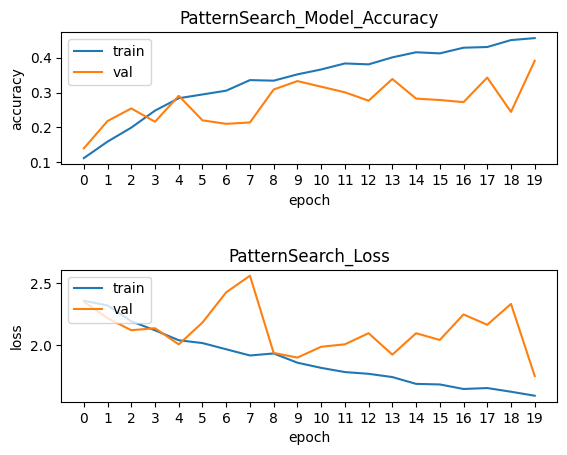

In [38]:
plt.subplot(211)
plt.plot(ps_sgd_history.history['accuracy'])
plt.plot(ps_sgd_history.history['val_accuracy'])
plt.title('PatternSearch_Model_Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 20, 1))
plt.subplot(212)
plt.plot(ps_sgd_history.history['loss'])
plt.plot(ps_sgd_history.history['val_loss'])
plt.title('PatternSearch_Loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplots_adjust(hspace=0.8)
plt.xticks(np.arange(0, 20, 1))
# plt.show()
images_dir = '/content/drive/MyDrive/pruthvirai/CIFAR_CNN'
plt.savefig(f"{images_dir}/patternsearch_sgd.png")

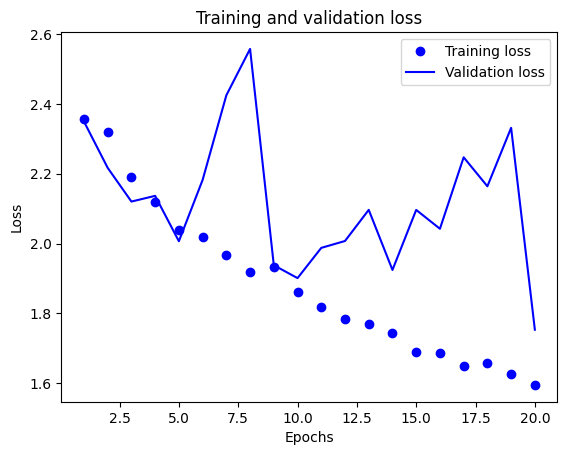

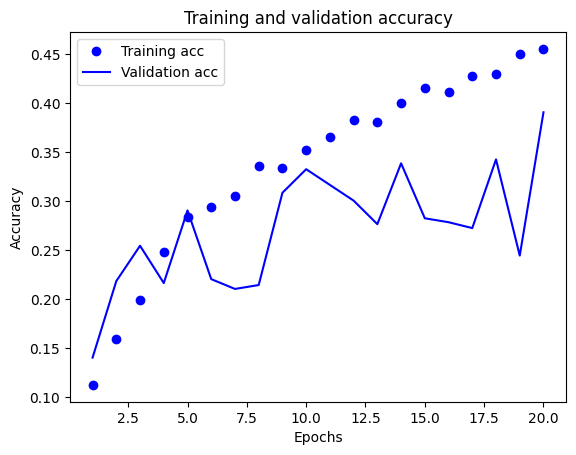

In [19]:
def plot_learning_curves(history):
    train_loss = ps_sgd_history.history['loss']
    val_loss = ps_sgd_history.history['val_loss']
    train_acc = ps_sgd_history.history['accuracy']
    val_acc = ps_sgd_history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, train_acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_learning_curves(ps_sgd_history)

In [20]:
preds = model.predict(x_train)
y_pred = np.argmax(preds, axis=1)
y_train1 = np.argmax(y_train, axis=1)
print(classification_report(y_train1, y_pred))
print(confusion_matrix(y_train1,y_pred))

157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.67      0.39      0.49       505
           1       0.77      0.33      0.46       460
           2       0.52      0.15      0.24       519
           3       0.45      0.19      0.27       486
           4       0.46      0.36      0.40       519
           5       0.30      0.67      0.42       488
           6       0.43      0.68      0.53       518
           7       0.58      0.40      0.47       486
           8       0.68      0.35      0.46       520
           9       0.35      0.85      0.49       498

    accuracy                           0.44      4999
   macro avg       0.52      0.44      0.42      4999
weighted avg       0.52      0.44      0.42      4999

[[195  11  26   6  12  48   7  19  53 128]
 [  3 150   0   3   3  33  17  10   7 234]
 [ 16   1  79  23  85 144 104  23  10  34]
 [  1   2   9  94  21 189 109   7   0  54]
 [ 11   3  10 

In [21]:
preds = model.predict(x_test)
y_pred = np.argmax(preds, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(classification_report(y_test1, y_pred))
print(confusion_matrix(y_test1,y_pred))

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.53      0.28      0.37        57
           1       0.61      0.27      0.37        41
           2       0.78      0.14      0.23        51
           3       0.37      0.15      0.21        48
           4       0.28      0.20      0.23        40
           5       0.24      0.54      0.33        48
           6       0.45      0.70      0.55        54
           7       0.41      0.32      0.36        47
           8       0.56      0.32      0.40        57
           9       0.37      0.88      0.52        56

    accuracy                           0.39       499
   macro avg       0.46      0.38      0.36       499
weighted avg       0.46      0.39      0.36       499

[[16  0  1  0  0  8  2  4  5 21]
 [ 0 11  0  0  0  1  2  1  3 23]
 [ 2  1  7  2  5 19 11  1  2  1]
 [ 0  0  0  7  5 19 11  1  0  5]
 [ 2  1  0  0  8 11 10  5  1  2]
 [ 1  0  0  3  3 26  5 

## Adam

In [27]:
import time
start = time.time()
# Define function to evaluate hyperparameters
def evaluate_hyperparameters(hyperparameters):
  # Define model architecture
  model = Sequential()
  model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:],activation='relu'))
  model.add(Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1(0.0001)))

  # Compile model with Adam optimizer and given learning rate, beta_1 and beta_2
  optimizer = Adam(learning_rate=hyperparameters['learning_rate'], beta_1=hyperparameters['beta_1'], beta_2=hyperparameters['beta_2'])
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Train model
  history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), verbose=0)

  # Return validation accuracy
  return history

# Define function to perform pattern search hyperparameter optimization
def pattern_search_hyperparameter_optimization():
  # Initialize hyperparameters
  current_hyperparameters = {
      'learning_rate': np.random.uniform(0.0001, 0.01),
      'beta_1': np.random.uniform(0.8, 0.99),
      'beta_2': np.random.uniform(0.8, 0.99)
  }

  # Initialize search direction
  search_direction = {
      'learning_rate': 1.0,
      'beta_1': 8.0,
      'beta_2': 8.0
  }

  # Initialize step size
  step_size = 0.01

  # Initialize best hyperparameters and validation accuracy
  best_hyperparameters = current_hyperparameters.copy()
  best_validation_accuracy = -1

  # Define number of iterations and convergence threshold
  max_iterations = 20
  convergence_threshold = 0.001

  # Perform pattern search hyperparameter optimization
  for i in range(max_iterations):
      print(f'Iteration {i+1}:')
      print(f'Current hyperparameters: {current_hyperparameters}')
      history = evaluate_hyperparameters(current_hyperparameters)
      val_accuracy = history.history['val_accuracy'][-1]
      print(f'Current validation accuracy: {val_accuracy}')
      print(f'Best hyperparameters: {best_hyperparameters}')
      print(f'Best validation accuracy: {best_validation_accuracy}')

      # Update best hyperparameters if current validation accuracy is higher
      if val_accuracy > best_validation_accuracy:
          best_hyperparameters = current_hyperparameters.copy()
          best_validation_accuracy = val_accuracy

      # Evaluate hyperparameters in positive search direction
      positive_hyperparameters = {
          'learning_rate': current_hyperparameters['learning_rate'] + search_direction['learning_rate'] * step_size,
          'beta_1': current_hyperparameters['beta_1'] + search_direction['beta_1'] * step_size,
          'beta_2': current_hyperparameters['beta_2'] + search_direction['beta_2'] * step_size
      }
      positive_history = evaluate_hyperparameters(positive_hyperparameters)
      positive_val_accuracy = positive_history.history['val_accuracy'][-1]

      # Evaluate hyperparameters in negative search direction
      negative_hyperparameters = {
          'learning_rate': current_hyperparameters['learning_rate'] - search_direction['learning_rate'] * step_size,
          'beta_1': current_hyperparameters['beta_1'] - search_direction['beta_1'] * step_size,
          'beta_2': current_hyperparameters['beta_2'] + search_direction['beta_2'] * step_size
      }
      negative_history = evaluate_hyperparameters(negative_hyperparameters)
      negative_val_accuracy = negative_history.history['val_accuracy'][-1]

      # Determine new search direction
      if positive_val_accuracy > best_validation_accuracy:
          current_hyperparameters = positive_hyperparameters
      elif negative_val_accuracy > best_validation_accuracy:
          current_hyperparameters = negative_hyperparameters
      else:
          step_size /= 2.0

  # Return the best hyperparameters and validation accuracy
  return best_hyperparameters, best_validation_accuracy
best_hyperparameters = pattern_search_hyperparameter_optimization()

Iteration 1:
Current hyperparameters: {'learning_rate': 0.00502252208318654, 'beta_1': 0.8814153426054234, 'beta_2': 0.9736267473570719}
Current validation accuracy: 0.509018063545227
Best hyperparameters: {'learning_rate': 0.00502252208318654, 'beta_1': 0.8814153426054234, 'beta_2': 0.9736267473570719}
Best validation accuracy: -1
Iteration 2:
Current hyperparameters: {'learning_rate': 0.00502252208318654, 'beta_1': 0.8814153426054234, 'beta_2': 0.9736267473570719}
Current validation accuracy: 0.4549098312854767
Best hyperparameters: {'learning_rate': 0.00502252208318654, 'beta_1': 0.8814153426054234, 'beta_2': 0.9736267473570719}
Best validation accuracy: 0.509018063545227
Iteration 3:
Current hyperparameters: {'learning_rate': 0.00502252208318654, 'beta_1': 0.8814153426054234, 'beta_2': 0.9736267473570719}
Current validation accuracy: 0.5010020136833191
Best hyperparameters: {'learning_rate': 0.00502252208318654, 'beta_1': 0.8814153426054234, 'beta_2': 0.9736267473570719}
Best valid

In [28]:
# Best Parameters
Best_hyperparameters = best_hyperparameters[0]

In [29]:
def model(hyperparameters):
    # Define model architecture
    use_saved_model = False
    if use_saved_model:
      model = keras.models.load_model("/content/drive/MyDrive/pruthvirai/CIFAR_CNN/PatternSearch_Adam.model")
      return model
    else:
      model = Sequential()
      model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:],activation='relu'))
      model.add(Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu'))
      model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
      model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
      model.add(Dropout(0.5))
      model.add(Flatten())
      model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1(0.0001)))

      # Compile model with Adam optimizer and given learning rate and momentum
      optimizer = Adam(learning_rate=hyperparameters['learning_rate'], beta_1=hyperparameters['beta_1'], beta_2=hyperparameters['beta_2'])
      model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      
      # Train model
      ps_adam_history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), verbose=0)

      # Return validation accuracy
      return model, ps_adam_history

In [30]:
model, ps_adam_history = model(Best_hyperparameters)
end = time.time()
print(f"Runtime of the program is {end - start}")

In [31]:
model.save("/content/drive/MyDrive/pruthvirai/CIFAR_CNN/PatternSearch_Adam.model")

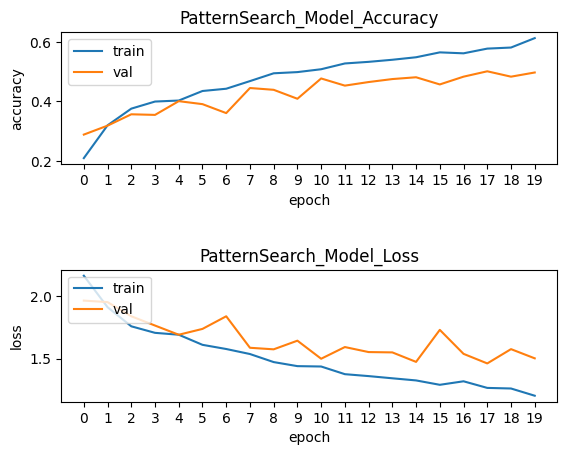

In [37]:
plt.subplot(211)
plt.plot(ps_adam_history.history['accuracy'])
plt.plot(ps_adam_history.history['val_accuracy'])
plt.title('PatternSearch_Model_Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 20, 1))
plt.subplot(212)
plt.plot(ps_adam_history.history['loss'])
plt.plot(ps_adam_history.history['val_loss'])
plt.title('PatternSearch_Model_Loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplots_adjust(hspace=0.8)
plt.xticks(np.arange(0, 20, 1))
# plt.show()
images_dir = '/content/drive/MyDrive/pruthvirai/CIFAR_CNN'
plt.savefig(f"{images_dir}/patternsearch_adam.png")

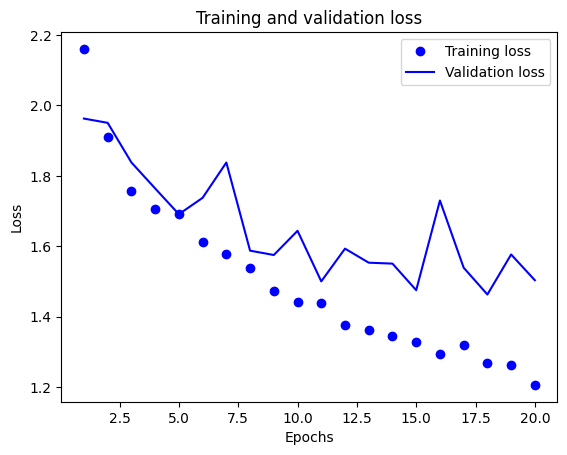

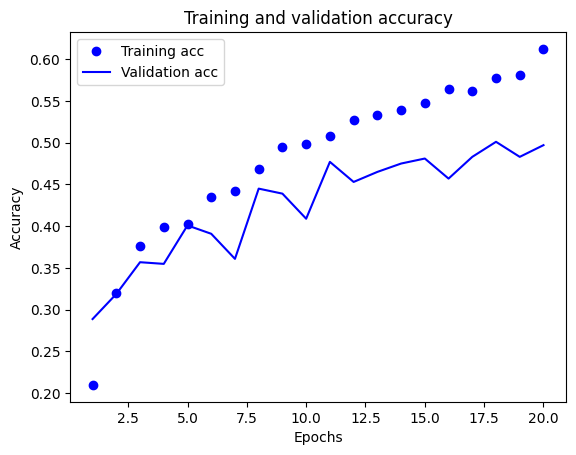

In [33]:
def plot_learning_curves(history):
    train_loss = ps_adam_history.history['loss']
    val_loss = ps_adam_history.history['val_loss']
    train_acc = ps_adam_history.history['accuracy']
    val_acc = ps_adam_history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, train_acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_learning_curves(ps_adam_history)

In [34]:
preds = model.predict(x_train)
y_pred = np.argmax(preds, axis=1)
y_train1 = np.argmax(y_train, axis=1)
print(classification_report(y_train1, y_pred))
print(confusion_matrix(y_train1,y_pred))

157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       505
           1       0.82      0.83      0.83       460
           2       0.70      0.52      0.60       519
           3       0.58      0.66      0.62       486
           4       0.69      0.54      0.61       519
           5       0.64      0.74      0.68       488
           6       0.77      0.71      0.74       518
           7       0.75      0.76      0.76       486
           8       0.83      0.77      0.80       520
           9       0.78      0.86      0.81       498

    accuracy                           0.72      4999
   macro avg       0.72      0.72      0.72      4999
weighted avg       0.72      0.72      0.72      4999

[[417  11   8   3   5   5   2   3  37  14]
 [  7 383   2   0   1   4   4   2  16  41]
 [ 50   8 272  45  42  40  28  22   6   6]
 [  8   6  11 322  21  60  22  13   4  19]
 [ 37   4  38 

In [35]:
preds = model.predict(x_test)
y_pred = np.argmax(preds, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(classification_report(y_test1, y_pred))
print(confusion_matrix(y_test1,y_pred))

16/16 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.44      0.47      0.46        57
           1       0.59      0.66      0.62        41
           2       0.53      0.33      0.41        51
           3       0.28      0.33      0.30        48
           4       0.29      0.17      0.22        40
           5       0.34      0.42      0.37        48
           6       0.69      0.61      0.65        54
           7       0.51      0.55      0.53        47
           8       0.59      0.53      0.56        57
           9       0.64      0.80      0.71        56

    accuracy                           0.50       499
   macro avg       0.49      0.49      0.48       499
weighted avg       0.50      0.50      0.49       499

[[27  3  1  1  0  2  2  3 12  6]
 [ 1 27  1  0  1  0  0  0  4  7]
 [ 8  2 17  5  5  7  5  1  0  1]
 [ 2  1  3 16  3 12  5  5  0  1]
 [ 4  1  5  5  7  6  3  6  0  3]
 [ 0  0  2 14  4 20  0 